#Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading dataset
labels = pd.read_csv('/content/drive/MyDrive/ComputerVision/Labels.csv')

# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/ComputerVision/images.npy')

## Data Overview

### Understand the shape of the dataset

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

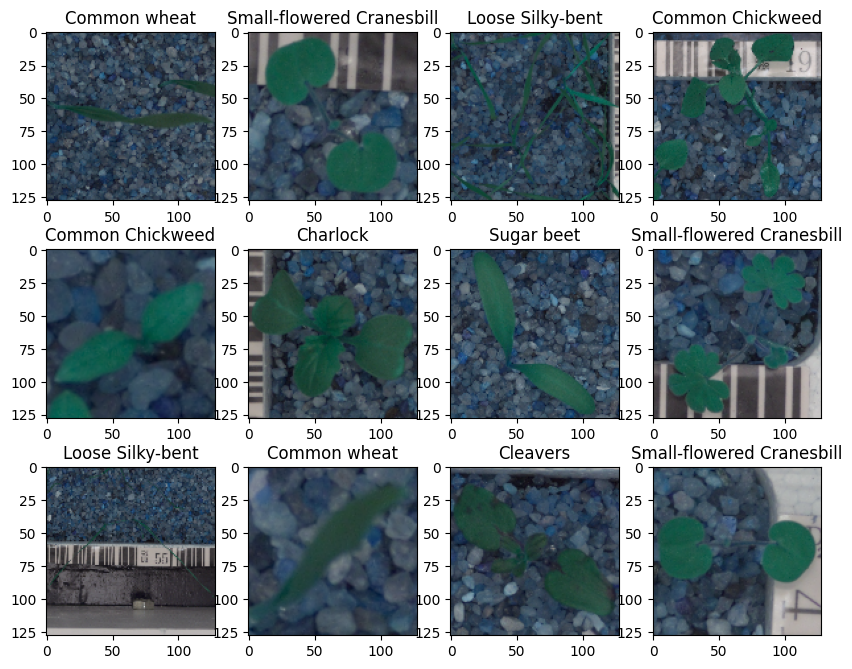

In [ ]:
plot_images(images,labels)

<b> Checking for data imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

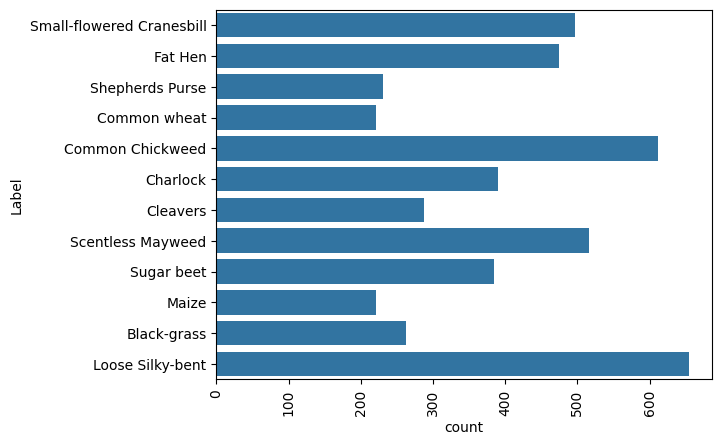

In [ ]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is imbalanced. We will use class weights to address this.


## Data Pre-Processing

### Convert the BGR images to RGB images.

## Plotting images using OpenCV and matplotlib

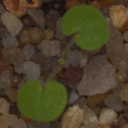

In [ ]:
cv2_imshow(images[5])

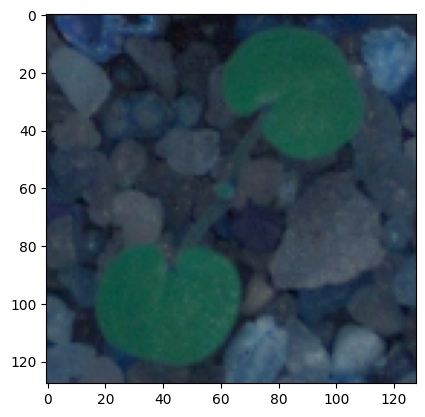

In [ ]:
plt.imshow(images[5])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- Now we will convert these BGR images to RGB images so we could interpret them easily.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

### Data Preparation for Modeling

- Before we proceed to build a model, we need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- We will encode categorical features and scale the pixel values.
- We will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


In [ ]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

### Encode the target labels

In [ ]:
 #Convert labels from names to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)


In [ ]:
print(X_train.shape,y_train_encoded.shape)
print(X_val.shape,y_val_encoded.shape)


(3847, 64, 64, 3) (3847, 12)
(428, 64, 64, 3) (428, 12)


### Data Normalization

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## Model Building

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [ ]:
# Intializing a sequential model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(64, 64, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                        

### <b> Fitting the model on the train data

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=35,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=75,
            verbose=2,
            class_weight=class_weights
)

Epoch 1/35
52/52 - 27s - loss: 3.0029 - accuracy: 0.2794 - val_loss: 5.8903 - val_accuracy: 0.1379 - 27s/epoch - 516ms/step
Epoch 2/35
52/52 - 4s - loss: 1.9432 - accuracy: 0.4604 - val_loss: 12.7300 - val_accuracy: 0.1379 - 4s/epoch - 68ms/step
Epoch 3/35
52/52 - 4s - loss: 1.4891 - accuracy: 0.5547 - val_loss: 18.1374 - val_accuracy: 0.1379 - 4s/epoch - 69ms/step
Epoch 4/35
52/52 - 4s - loss: 1.2215 - accuracy: 0.6236 - val_loss: 14.0361 - val_accuracy: 0.1379 - 4s/epoch - 71ms/step
Epoch 5/35
52/52 - 4s - loss: 1.0051 - accuracy: 0.6834 - val_loss: 16.0766 - val_accuracy: 0.1379 - 4s/epoch - 68ms/step
Epoch 6/35
52/52 - 4s - loss: 0.8918 - accuracy: 0.7234 - val_loss: 13.7198 - val_accuracy: 0.1379 - 4s/epoch - 68ms/step
Epoch 7/35
52/52 - 3s - loss: 0.8057 - accuracy: 0.7440 - val_loss: 10.9997 - val_accuracy: 0.1379 - 3s/epoch - 67ms/step
Epoch 8/35
52/52 - 4s - loss: 0.6099 - accuracy: 0.8040 - val_loss: 8.9732 - val_accuracy: 0.1449 - 4s/epoch - 68ms/step
Epoch 9/35
52/52 - 3s -

### **Model Evaluation**

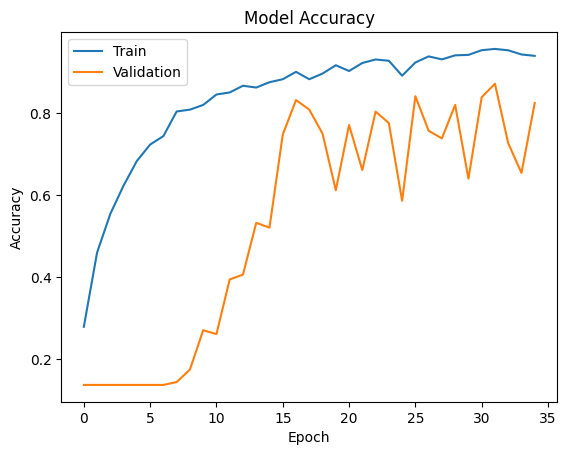

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not good.**
*   The model seems to overfit on the data.






### **Evaluating the model on test data**

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.7869 - accuracy: 0.8042 - 1s/epoch - 93ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 9ms/step


In [ ]:
y_pred

array([[1.2055661e-10, 2.9330327e-10, 2.6116371e-09, ..., 1.1641907e-09,
        3.6266459e-09, 2.5121043e-09],
       [4.4369735e-09, 5.5179999e-06, 2.2413136e-08, ..., 2.0010389e-06,
        9.9999070e-01, 5.6045430e-08],
       [9.2440278e-09, 1.1792673e-06, 1.7338611e-07, ..., 8.7495494e-07,
        9.9995840e-01, 1.2618416e-07],
       ...,
       [4.6755862e-01, 2.2042441e-06, 3.3077411e-06, ..., 4.1732337e-06,
        2.3823197e-06, 6.2901876e-07],
       [4.6843172e-05, 1.1706874e-05, 9.9141747e-05, ..., 1.8875683e-03,
        5.3826739e-06, 1.2143615e-04],
       [3.6181170e-06, 2.9281105e-03, 2.1548023e-05, ..., 1.3250777e-01,
        8.6233377e-01, 3.1195430e-04]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





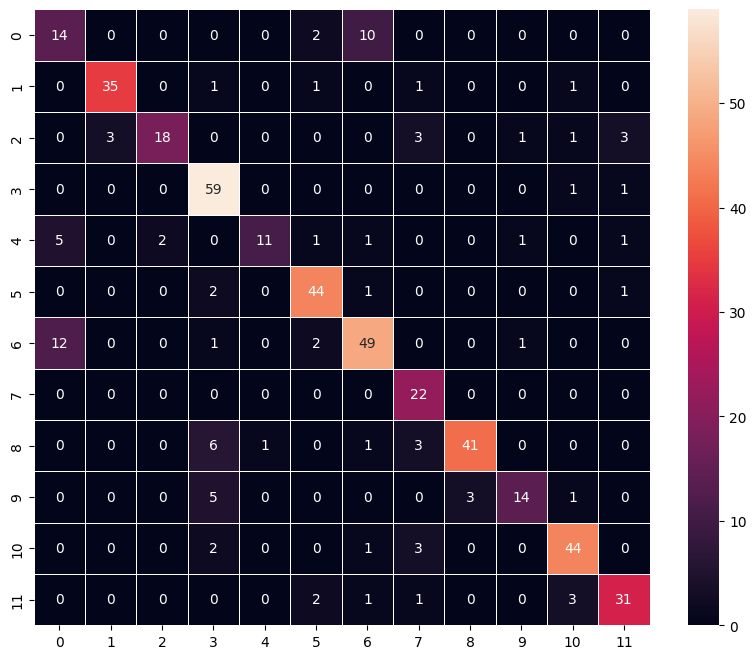

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- We see that model is giving high accuracy on train but low on validation and test, meaning overfitting.
- We can will try to address overfitting using data augmentation.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model2 = Sequential()
model2.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(64, 64, 3), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))
model2.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))
model2.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(12, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                        

### <b> Fitting the model on the train data

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=3,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.00001)
history_2 = model2.fit(
            X_train_normalized, y_train_encoded,
            epochs=35,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=75,
            callbacks=[reduce_lr],
            verbose=2,
            class_weight=class_weights
)



Epoch 1/35
52/52 - 9s - loss: 3.0038 - accuracy: 0.2722 - val_loss: 9.5641 - val_accuracy: 0.1379 - lr: 0.0010 - 9s/epoch - 174ms/step
Epoch 2/35
52/52 - 3s - loss: 1.9135 - accuracy: 0.4604 - val_loss: 15.4444 - val_accuracy: 0.1379 - lr: 0.0010 - 3s/epoch - 67ms/step
Epoch 3/35
52/52 - 3s - loss: 1.4295 - accuracy: 0.5607 - val_loss: 18.6765 - val_accuracy: 0.1379 - lr: 0.0010 - 3s/epoch - 66ms/step
Epoch 4/35

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
52/52 - 4s - loss: 1.1824 - accuracy: 0.6395 - val_loss: 17.2203 - val_accuracy: 0.1379 - lr: 0.0010 - 4s/epoch - 68ms/step
Epoch 5/35
52/52 - 4s - loss: 0.9426 - accuracy: 0.6995 - val_loss: 14.0599 - val_accuracy: 0.1379 - lr: 4.0000e-04 - 4s/epoch - 70ms/step
Epoch 6/35
52/52 - 4s - loss: 0.8136 - accuracy: 0.7434 - val_loss: 9.1683 - val_accuracy: 0.1379 - lr: 4.0000e-04 - 4s/epoch - 69ms/step
Epoch 7/35

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
52/52 - 4s - loss

### **Model Evaluation**

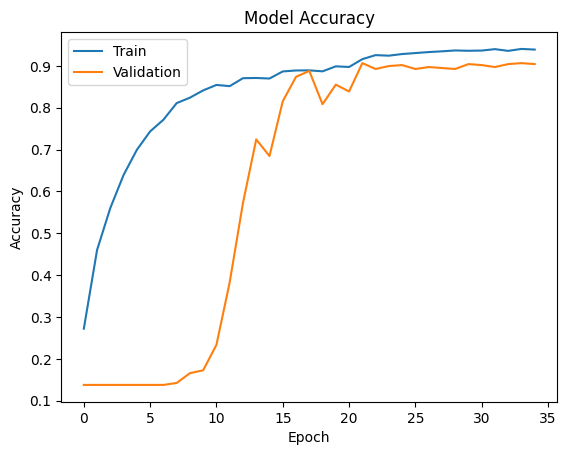

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model is good but the validation  & test accuracy are not close to training.**
*   The model seems to overfit on the data.






### **Evaluating the model on test data**

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.3914 - accuracy: 0.8842 - 178ms/epoch - 12ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 9ms/step


In [ ]:
y_pred

array([[1.8326411e-06, 5.9220105e-07, 1.2176604e-06, ..., 3.4346360e-06,
        2.8915169e-06, 1.6446460e-05],
       [1.5993045e-06, 1.4320196e-04, 1.1917919e-05, ..., 8.0341808e-05,
        9.9946493e-01, 4.4261719e-06],
       [2.1831436e-07, 5.3808685e-06, 7.0298856e-06, ..., 4.0307109e-06,
        9.9996006e-01, 1.2605850e-06],
       ...,
       [5.5552548e-01, 4.3473463e-04, 4.6472205e-04, ..., 5.3828303e-04,
        1.3114889e-04, 7.6546095e-04],
       [4.9453811e-04, 1.9778553e-04, 1.6346169e-03, ..., 2.2605704e-02,
        1.7343818e-04, 1.3113426e-03],
       [2.3150253e-05, 2.8648111e-04, 1.4163767e-03, ..., 7.5648800e-03,
        9.8914540e-01, 1.7084592e-04]], dtype=float32)

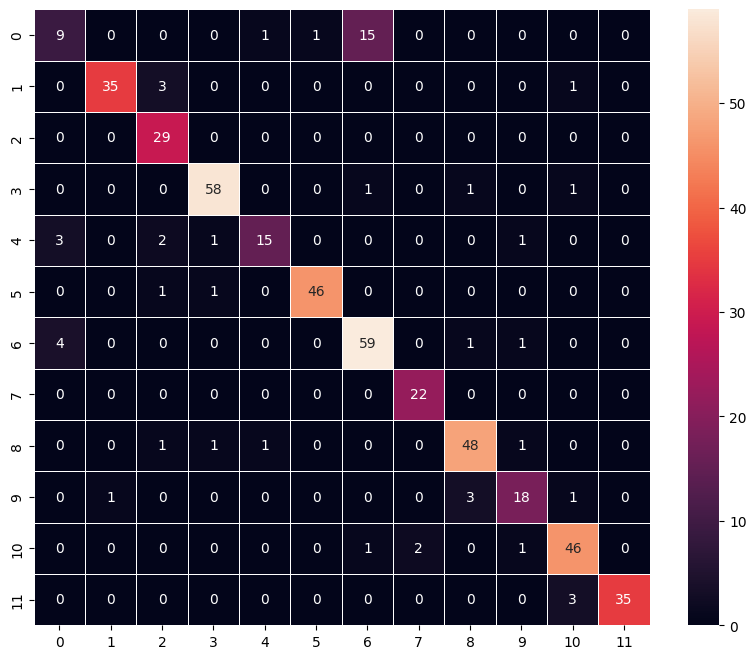

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that the model2 is doing better than model 1 expect for class 0 other classes have good prediction.
- We observed overfitting in this model as well, we will try to address overfitting using data augmentation.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Data Augmentaion.
#train_datagen = ImageDataGenerator(rotation_range = 20,zoom_range = 0.2,width_shift_range = 0.2,height_shift_range = 0.2,horizontal_flip = True, shear_range = 0.2)
train_datagen = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)


In [ ]:
# Intializing a sequential model
model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(64, 64, 3), activation='relu'))
model3.add(BatchNormalization(axis=3))
model3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(BatchNormalization(axis=3))
model3.add(Dropout(0.1))
model3.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model3.add(BatchNormalization(axis=3))
model3.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(BatchNormalization(axis=3))
model3.add(Dropout(0.1))
model3.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model3.add(BatchNormalization(axis=3))
model3.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(BatchNormalization(axis=3))
model3.add(Dropout(0.1))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(12, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                        

In [ ]:

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=3,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.00001)
history = model3.fit(
            train_datagen.flow(X_train_normalized,y_train_encoded,
                                       seed=42,
                                       shuffle=False),
            epochs=35,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=75,
            callbacks=[reduce_lr],
            verbose=2,
            class_weight=class_weights
)


Epoch 1/35
121/121 - 15s - loss: 3.1120 - accuracy: 0.2464 - val_loss: 15.2439 - val_accuracy: 0.1379 - lr: 0.0010 - 15s/epoch - 124ms/step
Epoch 2/35
121/121 - 8s - loss: 2.1474 - accuracy: 0.3962 - val_loss: 13.3653 - val_accuracy: 0.1379 - lr: 0.0010 - 8s/epoch - 65ms/step
Epoch 3/35
121/121 - 6s - loss: 1.7648 - accuracy: 0.4676 - val_loss: 5.3736 - val_accuracy: 0.1565 - lr: 0.0010 - 6s/epoch - 52ms/step
Epoch 4/35
121/121 - 6s - loss: 1.5284 - accuracy: 0.5285 - val_loss: 3.6454 - val_accuracy: 0.1682 - lr: 0.0010 - 6s/epoch - 52ms/step
Epoch 5/35
121/121 - 6s - loss: 1.4420 - accuracy: 0.5649 - val_loss: 2.4654 - val_accuracy: 0.4089 - lr: 0.0010 - 6s/epoch - 53ms/step
Epoch 6/35
121/121 - 7s - loss: 1.2436 - accuracy: 0.6153 - val_loss: 1.9640 - val_accuracy: 0.4509 - lr: 0.0010 - 7s/epoch - 59ms/step
Epoch 7/35
121/121 - 8s - loss: 1.1074 - accuracy: 0.6493 - val_loss: 1.6167 - val_accuracy: 0.5678 - lr: 0.0010 - 8s/epoch - 64ms/step
Epoch 8/35
121/121 - 8s - loss: 0.9781 - ac

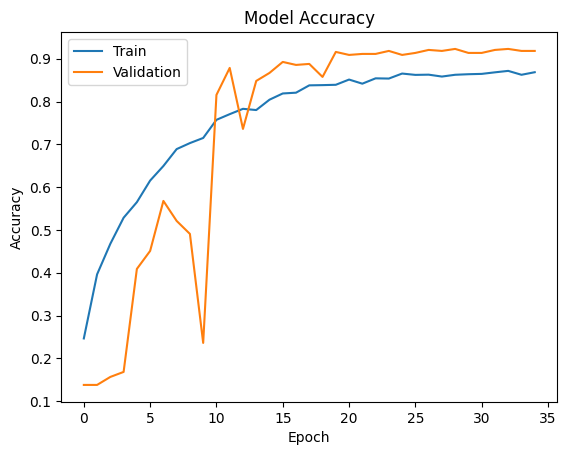

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.3037 - accuracy: 0.8989 - 139ms/epoch - 9ms/step


We can observe that our accuracy has improved compared to our previous model.

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model3.predict(X_test_normalized)

15/15 [==============================] - 0s 7ms/step


In [ ]:
y_pred

array([[6.3647567e-05, 1.9802726e-05, 2.0036221e-04, ..., 1.4982756e-03,
        3.0092133e-04, 1.7145269e-03],
       [3.9959818e-05, 1.9899206e-02, 8.5764966e-04, ..., 2.5960736e-03,
        9.4963831e-01, 7.7404387e-05],
       [1.3362433e-05, 7.6695345e-04, 5.9377973e-04, ..., 2.4684001e-04,
        9.9757892e-01, 1.6698104e-05],
       ...,
       [3.9171180e-01, 4.6585381e-04, 3.0614846e-04, ..., 1.2347699e-04,
        3.4042733e-04, 4.3827275e-04],
       [3.3261508e-04, 5.4183067e-04, 1.8099118e-03, ..., 4.7456097e-02,
        1.0675521e-04, 1.1081672e-02],
       [8.4212748e-05, 7.7559456e-02, 4.3425518e-03, ..., 8.7571090e-01,
        2.3007983e-02, 2.2712864e-03]], dtype=float32)

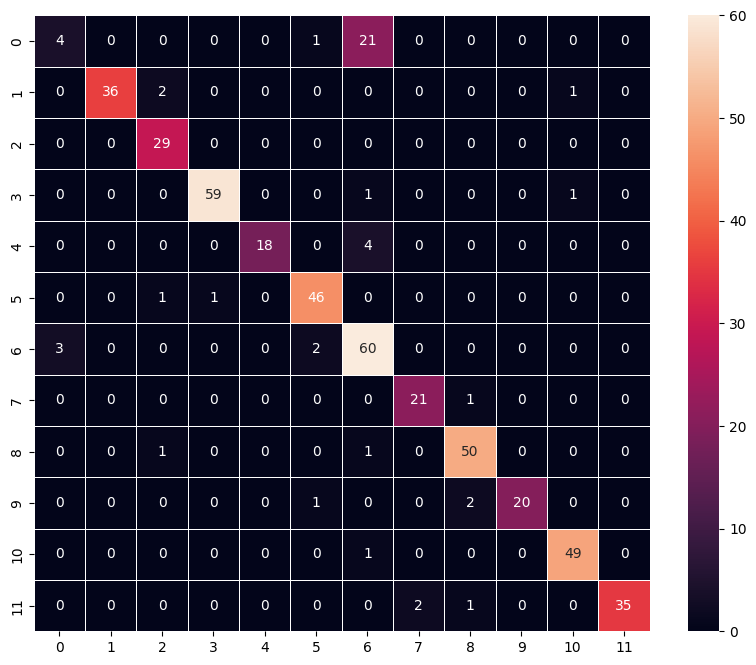

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- The confusion matrix is good, however there is still some confusion with the class 0 of Plant Seedlings.
- we can observe that the the training, validation & test accuracy are close, model is generalized has outperformed our previous models.
- Data Augmentation addressed the issue of overfitting quite well

### Visualizing the prediction

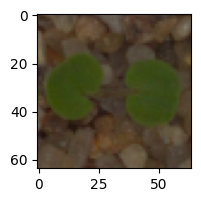

1/1 [==============================] - 0s 331ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


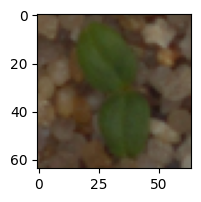

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Cleavers']
True Label Cleavers


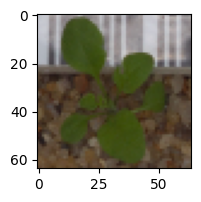

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [ ]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with ReduceLRonPlateau()', 'CNN Model with Data Augmentation'],'Train Accuracy':['93.94%','93.89%','86.85%'],'Validation Accuracy':['82.48%','90.42%','91.82%'],'Test Accuracy':['80.42%','88.42%','89.89%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,93.94%,82.48%,80.42%
1,CNN Model with ReduceLRonPlateau(),93.89%,90.42%,88.42%
2,CNN Model with Data Augmentation,86.85%,91.82%,89.89%


**Observation:**
- We have created 3 models
  - Base Model
  - Model with ReduceLRonPlateau()
  - Model with Data Augmentation
- Base model has huge accuracy variation between train & validation, test. Even though Model with ReduceLRonPlateau() reduced the variation among accuracies, model is still overfit. Finally Model with Data Augmentation gave close accuracies for all the data sets.
- Since Model with Data Augmentation is generalized and accuracies are close we will select this model as our final model.

## Actionable Insights and Business Recommendations

## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters(Ex: Spatial Dropout can be included).
- We can try removing the image background by using a mask.
- We can also try converting RGB images to HSV
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

## Business Recommendations
- By incorporating above mentioned improvement techniques we can increase the model accuracy.

_____